# Paper 3 (Linear stability analysis plots and simulations)
2022-03-17 Version 0.1

In [29]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os

In [30]:

sw_lambda=1.1     # SW range
tau = -0.1        # tau = T/T_IN -1; negative values imply that the nematic phase is stable.


# Initial conditions
n_wavelengths = 2 # n_wavelengths es el número de longitudes de onda que caben en la caja, use only powers of two

s0= 0.001
Ampl = 0.001 # Ampl es la amplitud de la perturbación


# Time steps
nTimeSteps   =  100  # total number of time steps to run
print_period =  10  # number of time steps between program printouts


# Parameters for the scaled dynamical equations

# Finite differences grid parameters
L = 256    # Physical spatial size
N = L+2   # Augmented grid size with two extra points for PBC buffers
nb = 1    # numero de bloques (quizás nb por notebook), el número de veces que se repite una iteración
dx = 1.0      # pixel size
dt = 0.01     # time step

T_total = nTimeSteps*dt  # Total simulation time



In [31]:
# Define the fixed concentration scale phi = r_0/alpha,
# so that rho = (N/V) sigma^3 is given as rho = phi * c.

# Parameter phi =  8.0/7.0 approximately, according
# to the Paper 2 analysis of the decrease of the clearing point temperature
# with increasing nanoparticle volume fraction.

phi = 8.0/7.0

# Parameter mu_bar_0 = epsilon/(sigma**3 * alpha)
mu_bar_0 = 0.1  # Wild guess at the ratio of SW molecular density energy to NP+LC coupling parameter

In [32]:
## Square well free energy parameters

# Define parameters for the SW free energy, at selected values of lambda, 
# as given by Sastre et al. https://doi.org/10.1080/00268976.2017.1392051

b0 = {
    1.1:   -0.74484,
    1.2:   -1.51817,
    1.3:   -2.40494,
    1.4:   -3.46854,
    1.5:   -4.74229,
    1.6:   -6.24987,
    1.7:   -8.01193,
    1.8:   -10.0523
}

b1 = {
    1.1:   -0.382173,
    1.2:   -1.58568,
    1.3:   -3.04343,
    1.4:   -4.36238,
    1.5:   -5.34853,
    1.6:   -5.88535,
    1.7:   -5.8906,
    1.8:   -5.27555
}

b2 = {
    1.1:    -1.63313,
    1.2:    -1.40168,
    1.3:    -1.16285,
    1.4:     1.46006,
    1.5:     3.10155,
    1.6:     4.48369,
    1.7:     5.34814,
    1.8:     5.38749
}

In [33]:
# For lambda = 1.1, A2 = a0 rho* + a1 rho*^2 + a2 rho*^3
a0=-0.315714
a1=-0.405783
a2=0.4394

# Matrix A collects constants for cases lambda> 1.1, 
# when A2 = g2 rho* exp(-h2 rho*^2) + f2 tanh( c2 rho*)  
#  g2,        h2,     f2,        c2
#A=np.array( [[0,0,0,0],
#   [-0.754123,1.54113, 0       , 0     ],    # lambda = 1.20
#   [-0.400299,4.81518,-0.221092,3.42486],    # lambda = 1.30
#   [-0.311957,9.62637,-0.275382,4.80383],    # lambda = 1.40
#   [-0.301985,12.7563,-0.305239,6.10676],    # lambda = 1.50
#   [-0.242938,10.8684,-0.333435,7.67705],    # lambda = 1.60
#   [-0.310091,16.5368,-0.376464,8.31355],    # lambda = 1.70
#   [ 0.385677,1.98941,-0.539128,8.40071]])   # lambda = 1.80, WARNING g2 was (-) in Ref.


g2 = {
    1.2:    -0.754123,
    1.3:    -0.400299,
    1.4:    -0.311957,
    1.5:    -0.301985,
    1.6:    -0.242938,
    1.7:    -0.310091,
    1.8:     0.385677    # WARNING g2 was incorrectly given as negative for lambda = 1.80 in
                         # Sastre et al. https://doi.org/10.1080/00268976.2017.1392051
}

h2 = {
    1.2:    1.54113,
    1.3:    4.81518,
    1.4:    9.62637,
    1.5:    12.7563,
    1.6:    10.8684,
    1.7:    16.5368,
    1.8:    1.98941,
}

f2 = {
    1.2:     0.000000,
    1.3:    -0.221092,
    1.4:    -0.275382,
    1.5:    -0.305239,
    1.6:    -0.333435,
    1.7:    -0.376464,
    1.8:    -0.539128,
}

c2 = {
    1.2:   0.00000,
    1.3:   3.42486,
    1.4:   4.80383,
    1.5:   6.10676,
    1.6:   7.67705,
    1.7:   8.31355,
    1.8:   8.40071
}

### Hard sphere aHS

In [34]:
# We use _c_ as our scaled concentration variable, with  rho* = phi c.
# noinspection PyPep8Naming
def aHS(eta):
#    rho = phi*c
#    eta = math.pi/6.0 * rho
    result= (4.0*eta - 3.0*eta**2)/(1.0-eta)**2
    return result

# First derivative of aHS with respect to eta
def daHS(eta):
#    rho = phi*c
#    eta = math.pi/6.0 * rho
    result =2.0*(2.0-eta)/(1.0-eta)**3
    return result


# First derivative of aHS with respect to eta
def d2aHS(eta):
#    rho = phi*c
#    eta = math.pi/6.0 * rho
    result =(10.0-4.0*eta)/(1-eta)**4
    return result


### First order in $\beta  = \frac{1}{k T}$

In [35]:
# Free energy perturbation A1
def A1(rho, Lambda):
    # with b0, b1 and b2 as dictionaries that depend on Lambda,
    # the first order perturbation term is
    # A1 = b0*rho* + b1*rho*^2 + b2*rho*^3.

#    rho = phi*c
    result= b0[Lambda] * rho + b1[Lambda] * rho**2 + b2[Lambda] * rho**3
    return result

# First Derivative of A1 with respect to rho*
def dA1(rho, Lambda):
#    rho = phi*c
    result = b0[Lambda] + 2.0 * b1[Lambda]  * rho + 3.0 * b2[Lambda] * rho**2
    return result

# Second Derivative of A1 with respect to rho*
def d2A1(rho, Lambda):
#    rho = phi*c
    result =  2.0 * b1[Lambda]  + 6.0 * b2[Lambda] * rho
    return result


### Second order in $\beta$ 

In [36]:
# Free energy perturbation A2 
def A2(rho, Lambda):
#    rho = phi*c
    
    if abs(Lambda-1.10) <= 0.05:
        result= a0 * rho + a1 * rho**2 + a2 * rho**3
    else:
        #      A[0]         A[1]         A[2]     A[3]
        # A2 = g2 rho* exp(-h2 rho*^2) + f2 tanh( c2 rho*)
        result=g2[Lambda] * rho * math.exp( -h2[Lambda] * rho**2) + f2[Lambda] * math.tanh(c2[Lambda] * rho)
    return result

# First derivative of A2 with respect to rho*
def dA2(rho, Lambda):
#    rho = phi*c

    if abs(Lambda-1.10) <= 0.05:
        result = a0 + 2.0* a1  * rho + 3.0 * a2 * rho**2
    else:
        result =(
                  g2[Lambda] * math.exp( -(h2[Lambda])*rho**2 )
                ) * (1.0- 2.0 * h2[Lambda] * rho**2) + \
                f2[Lambda] * c2[Lambda] /math.cosh(c2[Lambda]*rho)**2
    return result

# Second derivative of A2 with respect to rho*
def d2A2(rho, Lambda):
#    rho = phi*c

    if abs(Lambda-1.10) <= 0.05:
        result = 2.0 * a1  + 6.0 * a2 * rho
    else:
        result =(
                  2.0 * g2[Lambda] *h2[Lambda]* rho * math.exp( -(h2[Lambda])*rho**2 )
                ) * (-3.0 + 2.0 * h2[Lambda] * rho**2) - \
                2.0 * c2[Lambda]**2 * f2[Lambda] * math.cosh( c2[Lambda] *rho ) / math.cosh( c2[Lambda]*rho )**2
    return result




### Total free energy a_SW = A_SW/(N k T) 

In [37]:
def aSW(c,Lambda,T):
    rho = phi*c
    eta = math.pi/6.0 * rho

    result = aHS(eta) + A1(rho,Lambda)/T + A2(rho,Lambda)/T**2
    return result

## SW chemical potential

In [38]:
# Reduced chemical potential mu_bar:
def mu_bar(c, Lambda, T):

    rho = phi*c
    eta = math.pi/6.0 * rho

    result=                 ( aHS(eta)  + eta * daHS(eta)            ) + \
                  (1.0/T) * ( A1(rho,Lambda) + rho * dA1(rho,Lambda) ) + \
               (1.0/T**2) * ( A2(rho,Lambda) + rho * dA2(rho,Lambda) )

    result = mu_bar_0 * T * result
    return result


# Derivative of reduced chemical potential mu_bar, partial mu_bar/partial c:
def dmu_bar(c, Lambda, T):

    rho = phi*c
    eta = math.pi/6.0 * rho

    result= T * math.pi/6.0 * ( 2.0 * daHS(eta)       + eta * d2aHS(eta) ) + \
                                 ( 2.0 * dA1(rho,Lambda) + rho * d2A1(rho,Lambda) ) + \
                                 ( 2.0 * dA2(rho,Lambda) + rho * d2A2(rho,Lambda) ) / T
    result = mu_bar_0 * result
    return result

## Growth rates of Fourier modes from Linear Stability Analysis

### Fig 1A: Model C

In [39]:
# Growth rate associated to NP concentration
def sigma1_model_C(k, R):
   sigma = - R * k**2
   return sigma

# Growth rate associated to LC nematization
def sigma2_model_C(k, r, c0):
    sigma = -c0 -r -k**2
    return sigma



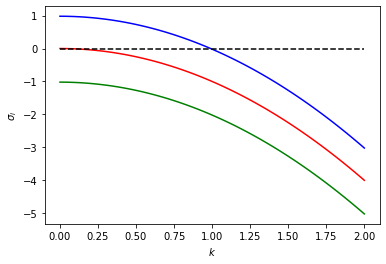

In [40]:
# Plot of Model C growth rates

# Generate list of wavenumbers
k_List = np.linspace(0.0, 2.0, 100)

# Generate list of zeros to show the x axis
zero_list = np.zeros(100)

# Evaluate NP-concentration growth rate
sigma1 = [sigma1_model_C(k, 1) for k in k_List]

# Evaluate LC-nematization growth rate (for nematic and isotropic cases)
sigma2_nematic   = [sigma2_model_C(k, -1.0, 0.02 ) for k in k_List]
sigma2_isotropic = [sigma2_model_C(k, 1.0, 0.02 ) for k in k_List]

# Plot sigma1 as red, sigma2 for isotropic phase as green and for nematic phase as blue.
# Color the x axis black
plt.plot(k_List, sigma1, 'r')
plt.plot(k_List, sigma2_isotropic, 'g')
plt.plot(k_List, sigma2_nematic, 'b')
plt.plot(k_List, zero_list, 'k--')

# Add labels to x and y axes, using LaTeX notation after "r"
plt.xlabel(r"$k$")
plt.ylabel(r"$\sigma_i$")

plt.show()


## Fig1B: Square well

In [41]:
# Growth rates

# Growth rate associated to NP concentration
def sigma1_sw(k, c0, Lambda, T, R):
   sigma = - R * dmu_bar(c0, Lambda, T) * k**2
   return sigma

# Growth rate associated to LC nematization
def sigma2_sw(k, c0, r):
    sigma = -c0 -r -k**2
    return sigma



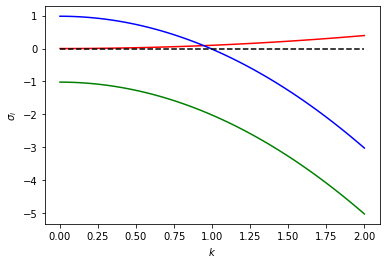

In [42]:
# Plot of growth rates
c0 = 0.02
Lambda = 1.2
T = 0.9
R  = 1.0

# Generate list of wavenumbers
k_List = np.linspace(0.0, 2.0, 100)

# Generate list of zeros to show the x axis
zero_list = np.zeros(100)

# Evaluate NP-concentration growth rate
sigma1 = [sigma1_sw(k, c0, Lambda, T, R) for k in k_List]

# Evaluate LC-nematization growth rate (for nematic and isotropic cases)
sigma2_nematic   = [sigma2_model_C(k, c0, -1 ) for k in k_List]
sigma2_isotropic = [sigma2_model_C(k,  c0, 1 ) for k in k_List]

# Plot sigma1 as red, sigma2 for isotropic phase as green and for nematic phase as blue.
# Color the x axis black
plt.plot(k_List, sigma1, 'r')
plt.plot(k_List, sigma2_isotropic, 'g')
plt.plot(k_List, sigma2_nematic, 'b')
plt.plot(k_List, zero_list, 'k--')

# Add labels to x and y axes, using LaTeX notation after "r"
plt.xlabel(r"$k$")
plt.ylabel(r"$\sigma_i$")

plt.show()

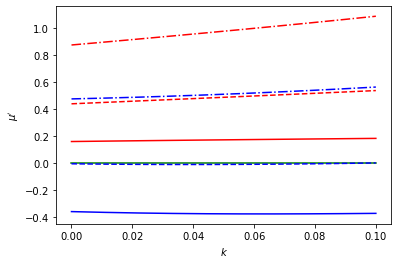

In [45]:
# Plot of A1  and dA1
c0 = 0.02
Lambda = 1.5
T = 2.5
R  = 1.0

# Generate 2D array of concentration and temperature

c_list = np.linspace(0.0, 0.1, 10)


# Generate list of zeros to show the x axis
zero_list = np.zeros(10)

# Evaluate NP-concentration growth rate
dmu_List_11_09 = [dmu_bar(c, 1.1, 0.9) for c in c_list]
dmu_List_11_15 = [dmu_bar(c, 1.1, 1.5) for c in c_list]
dmu_List_11_25 = [dmu_bar(c, 1.1, 2.5) for c in c_list]


dmu_List_12_09 = [dmu_bar(c, 1.2, 0.9) for c in c_list]
dmu_List_12_15 = [dmu_bar(c, 1.2, 1.5) for c in c_list]
dmu_List_12_25 = [dmu_bar(c, 1.2, 2.5) for c in c_list]

dmu_List_13_09 = [dmu_bar(c, 1.3, 0.9) for c in c_list]
dmu_List_13_15 = [dmu_bar(c, 1.3, 1.5) for c in c_list]
dmu_List_13_25 = [dmu_bar(c, 1.3, 2.5) for c in c_list]



# Plot sigma1 as red, sigma2 for isotropic phase as green and for nematic phase as blue.
# Color the x axis black
plt.plot(c_list, zero_list, 'g')

plt.plot(c_list, dmu_List_11_09, 'r')
plt.plot(c_list, dmu_List_11_15, 'r--')
plt.plot(c_list, dmu_List_11_25, 'r-.')

#plt.plot(c_list, dmu_List_12_09, 'g')
#plt.plot(c_list, dmu_List_12_15, 'g--')
#plt.plot(c_list, dmu_List_12_25, 'g-.')

plt.plot(c_list, dmu_List_13_09, 'b')
plt.plot(c_list, dmu_List_13_15, 'b--')
plt.plot(c_list, dmu_List_13_25, 'b-.')


# Add labels to x and y axes, using LaTeX notation after "r"
plt.xlabel(r"$k$")
plt.ylabel(r"$\mu'$")

plt.show()


